In [2]:
! load_ext autoreload
! autoreload 2
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, EulerAncestralDiscreteScheduler
import torch
import os
import math
import re
from itertools import groupby
from typing import Callable, Dict, List, Optional, Set, Tuple, Type, Union

import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('../')
from lora_diffusion import LoraInjectedConv2d, LoraInjectedLinear, patch_pipe, tune_lora_scale, parse_safeloras
from lora_diffusion.lora import _find_modules, UNET_CROSSATTN_TARGET_REPLACE, DEFAULT_TARGET_REPLACE
from reg_lora.visual import visualize_images
import safetensors
import time

os.environ["DISABLE_TELEMETRY"] = 'YES'
# os.environ["HTTP_PROXY"] = "http://localhost:7890"
# os.environ["HTTPS_PROXY"] = "http://localhost:7890"
model_id = "/data/zhicai/code/Text-regularized-customization/models/stable-diffusion-v1-5"
device = torch.device("cuda:3")
time.sleep(0.01)
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16,revision='39593d5650112b4cc580433f6b0435385882d819',local_files_only=True).to(device)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)


/bin/bash: load_ext: command not found
/bin/bash: autoreload: command not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
translation_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16, local_ckpt_files_only=True, revision='39593d5650112b4cc580433f6b0435385882d819').to(device)
translation_pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(
    translation_pipe.scheduler.config)
torch.manual_seed(0)

###  可视化 Attention map
在attn_layer中插入hook函数, 通过进行一轮采样，可视化对应层 name 中的attention map
 

In [ ]:
# %%capture
import os
import sys
sys.path.append('/home/zhicai/poseVideo/lora-master/')
path = 'outputs/checkpoints/debug_decay_0.001/lora_weight_e31_s5000.safetensors'
path = 'outputs/checkpoints/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e62_s10000.safetensors'
prompt = "'a <krk1> dog in grand canyon'"

command = f"python ../reg_lora/vis_attn_map.py --lora_path {path} --prompt {prompt} --gpu 0 --name up_blocks.2.attentions.1.transformer_blocks.0.attn2"
print(command)
os.system(command)

### 统计 Textual inversion 之后的 CLIP Similarity
这里统计的是 "photo of a <krk1> dog", "photo of a dog"的随着训练进程的CLIP相似度，同时"photo of a <krk1> dog"或者"photo of a dog"和训练图片随着训练进程的相似度

### Image and Caption 的 similarity

In [ ]:
import re
import os
import copy
import torch

from PIL import Image
from transformers import CLIPProcessor, CLIPModel
# from custom_datasets import LIVE_SUBJECT_PROMPT_LIST

target_dir = '/data/zhicai/code/Text-regularized-customization/outputs/dog/TiReg/TiReg_InitToken_weight_0_rank_10_seed_0'
ckpt_pattern = r'lora_weight_s\d{3,4}.safetensors'
root_img_path = '../custom_datasets/data/dog'
captions = ["photo of a <krk1> dog swimming in a pool",
            "photo of a <krk1> dog ",  "photo of a dog swimming in a pool"]
weight_dtype = torch.float32

# model = CLIPModel.from_pretrained(
#     "models/clip-vit-large-patch14").to(device, dtype=weight_dtype)
# processor = CLIPProcessor.from_pretrained("models/clip-vit-large-patch14")

images = [Image.open(os.path.join(root_img_path, img_path))
          for img_path in os.listdir(root_img_path)]


group = [ckpt_file for ckpt_file in os.listdir(
    target_dir) if '_s' in ckpt_file and 'lora_weight' in ckpt_file]
print(group)
sorted_group = sorted(group, key=lambda x: int(
    re.findall(r'.*s(\d+).*', x)[0]))[:20]

all_c2c_sim_list = []
all_c2i_sim_list = []
c2i_sim_list = []
c2c_sim_list = []
for _file in sorted_group:
    pipe_copy = copy.deepcopy(pipe).to(device)
    lora_path = os.path.join(target_dir, _file)
    print(f"loading from: {lora_path}")
    patch_pipe(
        pipe_copy,
        lora_path,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str='cross'
    )

    # processor.tokenizer = pipe_copy.tokenizer
    # model.text_model = copy.deepcopy(
    #     pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype))
    # # token_embedding = model.text_model.embeddings.token_embedding
    # # token_embedding.weight.data[49408] = token_embedding.weight.data[42170]
    # inputs = processor(text=captions, images=images,
    #                    return_tensors="pt", padding=True).to(device)
    # outputs = model(**inputs)

    # image_embeds = outputs.image_embeds
    # input_ids = inputs.input_ids
    # last_hidden_state = outputs.text_model_output.last_hidden_state
    # text_embeds = last_hidden_state[torch.arange(last_hidden_state.size(0), device=input_ids.device),
    #                                 [(row == 49407).nonzero().min() for row in input_ids]]
    # text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    # logit_scale = model.logit_scale.exp()
    # logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
    # logits_per_image = logits_per_text.t()
    # c2c_sim = torch.matmul(text_embeds, text_embeds.t())
    # c2c_sim_list.append(c2c_sim.detach().cpu().numpy())
    # # we can take the softmax to get the label probabilities
    # probs = logits_per_image.softmax(dim=1)
    # c2i_sim_list.append(probs[:, 0].mean().item())

all_c2c_sim_list.append(c2c_sim_list)
all_c2i_sim_list.append(c2i_sim_list)

### Text和 Text 之间的 similarity

In [4]:
import re
import os
import copy
import torch

from PIL import Image
from itertools import product
from transformers import CLIPProcessor, CLIPModel
from custom_datasets.utils import LIVE_SUBJECT_PROMPT_LIST

target_dir = '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/dog/TiReg/TiReg_norm0.37_weight_0_Init_rank_10_seed_0'
ckpt_pattern = r'lora_weight_s\d{3,4}.safetensors'
# captions = ["photo of a <krk1> dog swimming in a pool", "photo of a <krk1> dog ",  "photo of a dog swimming in a pool"]
weight_dtype = torch.float32
caption_lists = [
    [template.format('<krk1> dog'),
     "photo of a <krk1> dog",
     template.format('dog')]
    for template in LIVE_SUBJECT_PROMPT_LIST
]
model = CLIPModel.from_pretrained(
    "models/clip-vit-large-patch14",local_files_only=True).to(device, dtype=weight_dtype)


group = [ckpt_file for ckpt_file in os.listdir(
    target_dir) if '_s' in ckpt_file and 'lora_weight' in ckpt_file]
print(group)
sorted_group = sorted(group, key=lambda x: int(
    re.findall(r'.*s(\d+).*', x)[0]))[:20]

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like models/clip-vit-large-patch14 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
c2c_sim_outer_list = []
c2c_sim_iner_list = []
for _file in sorted_group:
    pipe_copy = copy.deepcopy(pipe).to(device)
    lora_path = os.path.join(target_dir, _file)
    print(f"loading from: {lora_path}")
    patch_pipe(
        pipe_copy,
        lora_path,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str='cross'
    )

    model.text_model = copy.deepcopy(
        pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype))
    # token_embedding = model.text_model.embeddings.token_embedding
    # token_embedding.weight.data[49408] = token_embedding.weight.data[42170]
    c2c_sim_iner_list = []
    for captions in caption_lists:
        input_ids = pipe_copy.tokenizer(
            captions, return_tensors="pt", padding=True).input_ids.to(device)
        outputs = pipe_copy.text_encoder.text_model(input_ids)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[torch.arange(last_hidden_state.size(0), device=input_ids.device),
                                          [(row == 49407).nonzero().min() for row in input_ids]]
        text_embeds = model.text_projection(pooled_output)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
        logit_scale = model.logit_scale.exp()
        c2c_sim = torch.matmul(text_embeds, text_embeds.t())
        diag_idx = torch.arange(min(c2c_sim.size(0), c2c_sim.size(1)))
        c2c_sim = c2c_sim[0, 1:]
        c2c_sim = torch.softmax(c2c_sim, dim=-1)
        c2c_sim_iner_list.append(c2c_sim.detach().cpu().numpy()[0])
    c2c_sim_outer_list.append(np.array(c2c_sim_iner_list))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


class MovAvg(object):
    def __init__(self, window_size=7):
        self.window_size = window_size
        self.data_queue = []

    def update(self, data):
        if len(self.data_queue) == self.window_size:
            del self.data_queue[0]
        self.data_queue.append(data)
        return sum(self.data_queue)/len(self.data_queue)


font = {'family': 'serif',
        'weight': 'normal',
        'size': 12,
        }

data = np.stack(c2c_sim_outer_list)

# 计算每列数据的均值和标准差
mean_values = np.mean(data, axis=1)
smooth_fn = MovAvg(2)
smoothed_mean_values = [smooth_fn.update(value) for value in mean_values]
std_values = np.std(data, axis=1)

x_labels = list(range(0, 100 * len(data), 100))

ax = plt.errorbar(x=x_labels, y=smoothed_mean_values, yerr=0.2 * std_values, c='black', capsize=0.4, marker='s',
                  ecolor='#79AC78', mec='#79AC78', mfc='#79AC78', ms=3, mew=4, alpha=0.7)

# plt.title()
plt.xticks(list(range(0, 100 * len(data) + 100, 200)))
plt.xlabel('steps', fontdict=font)
plt.ylabel('similarity', fontdict=font)
plt.grid(axis='x')
plt.show()

In [ ]:
from transformers.models.clip import CLIPTextModel

lora_path = '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/dog/TiReg/TiReg_weight_0_rank_10_seed_0/lora_weight_s2000.safetensors'
pipe_copy = copy.deepcopy(pipe).to(device)
patch_pipe(
    pipe_copy,
    lora_path,
    patch_text=False,
    patch_ti=True,
    patch_unet=True,
    filter_crossattn_str='cross'
)

prompt = ["a photo of a ktn dog swimming in a pool",
          "a photo of a <krk1> dog swimming in a pool"]
text_inputs = pipe_copy.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
device = pipe_copy.text_encoder.device
text_input_ids = text_inputs.input_ids.to(device)
global_eot_ids = [(row == 49407).nonzero().min() for row in text_input_ids]
bs = len(prompt)
outputs = pipe_copy.text_encoder(
    text_input_ids.to(device),
    attention_mask=None,
    output_attentions=True,
)
attentions = []

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# data = sns.load_dataset("flights")
# data = data.pivot("month", "year", "passengers")
attentions = []
for attention in outputs.attentions:
    attentions.append(attention.mean(dim=1)[torch.arange(
        bs, device=device), 11, :12].detach().cpu().numpy())
attentions = np.stack(attentions, axis=1)
idx = 1
data1 = attentions[idx].round(2)
xticklabels = ['<sot>'] + prompt[idx].split(' ') + ['<eot>']
yticklabels = np.arange(12) + 1
sns.set(font_scale=0.7)
ax = sns.heatmap(data1, annot=True, xticklabels=xticklabels,
                 yticklabels=yticklabels, linewidths=.5, cmap="YlGnBu")
ax.set_xlabel("prompt")
ax.set_ylabel("layer")
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# data = sns.load_dataset("flights")
# data = data.pivot("month", "year", "passengers")
prompt = ['a photo of a <new> dog swimming in a pool']
attentions = []
for attention in outputs.attentions:
    attentions.append(attention.mean(dim=1)[torch.arange(
        bs, device=device), 11, :12].detach().cpu().numpy())
attentions = np.stack(attentions, axis=1)
idx = 0
data2 = attentions[1].round(2) - attentions[0].round(2)
xticklabels = ['<sot>'] + prompt[idx].split(' ') + ['<eot>']
yticklabels = np.arange(12) + 1
sns.set(font_scale=0.7)
ax = sns.heatmap(data2, annot=True, xticklabels=xticklabels,
                 yticklabels=yticklabels, linewidths=.5, cmap="YlGnBu")
ax.set_xlabel("token")
ax.set_ylabel("text encoder layer")
plt.show()

In [ ]:
attentions.shape

### 统计Lora中的self和cross attn模块中的Linear-layer权重漂移和对语义漂移

In [ ]:
from lora_diffusion.lora import filter_unet_to_norm_weights
import copy
target_dir = '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/dog/TiReg/TiReg_weight_0_rank_10_seed_0'
test_prompts = ['a dog', 'a cat', 'a teddybear', 'a chair']
reg_prompt = ['photo of a ktn dog swimming in a pool']
custom_prompt = ['photo of a <krk1> dog swimming in a pool']

k_projected_reg_conditions = []
k_projected_input_conditions = []

# 找到cross_attn 和 self_attn的位置
cnt = 0


group = [ckpt_file for ckpt_file in os.listdir(
    target_dir) if '_s' in ckpt_file and 'lora_weight' in ckpt_file]
print(group)
sorted_group = sorted(group, key=lambda x: int(
    re.findall(r'.*s(\d+).*', x)[0]))[:20]

pipe_copy = copy.deepcopy(pipe).to(device)
for ckpt_file in sorted_group:
    cur_step_list_cross = []
    cur_step_context_reg_reside = []
    cur_step_list_self = []
    lora_ckpt = os.path.join(target_dir, ckpt_file)
    patch_pipe(
        pipe_copy,
        lora_ckpt,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str='cross'
    )
    tune_lora_scale(pipe_copy.unet, 0)
    reg_conditions = pipe_copy._encode_prompt(reg_prompt, device, 1, False)
    input_conditions = pipe_copy._encode_prompt(
        custom_prompt, device, 1, False)
    to_reg_params = filter_unet_to_norm_weights(
        pipe_copy.unet, target_replace_module=UNET_CROSSATTN_TARGET_REPLACE)
    layer_projected_input_conditions = []
    layer_projected_reg_conditions = []
    for module in to_reg_params["cross_project_k_loras"]:
        layer_projected_input_conditions.append(
            module.linear(input_conditions).norm(dim=-1))
        layer_projected_reg_conditions.append(
            module.linear(reg_conditions).norm(dim=-1))
    k_projected_reg_conditions.append(
        torch.stack(layer_projected_reg_conditions))
    k_projected_input_conditions.append(
        torch.stack(layer_projected_input_conditions))

In [ ]:
# ckpts, layers, 77
import seaborn as sns
import matplotlib.pyplot as plt
fig1 = k_projected_reg_conditions[-1].squeeze().detach().cpu().numpy().round(3)
fig2 = k_projected_input_conditions[-1].squeeze(
).detach().cpu().numpy().round(3)
plt.figure(figsize=(20, 10))
sns.set(font_scale=0.7)

ax = sns.heatmap(fig2, annot=False, linewidths=.5, cmap="YlGnBu")
ax.set_xlabel("layers")
ax.set_ylabel("tokens")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig2 = k_projected_input_conditions[0].squeeze(
).detach().cpu().numpy().round(3)
plt.figure(figsize=(20, 10))
sns.set(font_scale=0.7)

ax = sns.heatmap(fig2, annot=False, linewidths=.5, cmap="YlGnBu")
ax.set_xlabel("layers")
ax.set_ylabel("tokens")

In [ ]:
from reg_lora.vis_attn_map import add_attn_vis_hook, get_attn_softmax
name = 'up_blocks.2.attentions.1.transformer_blocks.0.attn2'
prompt = 'photo of a <krk1> dog swimming in a pool'
activation = {}
hooks = []
add_attn_vis_hook(pipe_copy.unet, name)
images = pipe_copy([prompt], num_inference_steps=50, guidance_scale=6).images
del pipe_copy
visualize_images(images,  nrow=1, outpath=path +
                 '_ori_img', show=True, save=False,)

attn_map = activation[name]
for i in range(len(attn_map)):
    #  attn_map is of shape [8+8 , 4096, 77]
    # then 40th sampling step
    if i == 40:
        fig_shape = int(math.sqrt(attn_map[i].size(1)))
        # reshape to (shape,shape) and average over heads
        vis_map = attn_map[i].reshape(
            attn_map[i].size(0), fig_shape, fig_shape, 77)
        uncond_attn_map, cond_attn_map = torch.chunk(vis_map, 2, dim=0)

        # mean over head [h, w, 77]
        cond_attn_map = cond_attn_map.mean(0)
        uncond_attn_map = uncond_attn_map.mean(0)

        fig, ax = plt.subplots(1, 10, figsize=(20, 2))
        for j in range(10):
            map = cond_attn_map[:, :, j].unsqueeze(-1).cpu().numpy()
            ax[j].imshow(map)
            # no axis for subplot
            ax[j].axis('off')
        # plt.savefig(f'{path}_attn_map.jpg')
        # plt.imshow(vis_map[:,:,2].cpu().numpy())
        # plt.close(fig)
        # print("saved attn map at ", f"{path}_attn_map.jpg")
        break

## Visualization figures

### 前置函数


In [ ]:
import copy
from functools import partial
import sys
import PIL.Image as Image


def patch_and_sample_lora_ckpts(pipe,
                                lora_ckpts,
                                prompts,
                                seed=0,
                                unet_scale=0,
                                bs=4,
                                filter_crossattn_str='cross',
                                num_inference_steps=50,
                                weight_dtype=torch.float16,):
    torch.manual_seed(seed)
    latents = torch.randn((bs, 4, 64, 64), device=device, dtype=weight_dtype)
    # pipe_copy.text_encoder = my_text_encoder
    img_list = []
    for lora_ckpt in lora_ckpts:
        pipe_copy = copy.deepcopy(pipe).to(device)
        torch.manual_seed(seed)
        patch_pipe(
            pipe_copy,
            lora_ckpt,
            patch_text=False,
            patch_ti=True,
            patch_unet=True,
            filter_crossattn_str=filter_crossattn_str
        )
        # pipe.unet
        tune_lora_scale(pipe_copy.unet, unet_scale)

        pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype)
        # tune_lora_scale(pipe_copy.text_encoder, 1)
        for prompt in prompts:
            prompt = [prompt]*bs
            img = pipe_copy(prompt=prompt,
                            num_inference_steps=num_inference_steps,
                            guidance_scale=6,
                            latents=latents,
                            callback=None,
                            callback_steps=1).images
            img_list.extend(img)
        del pipe_copy
    return img_list


def patch_and_translation_lora_ckpts(
        translation_pipe: StableDiffusionImg2ImgPipeline,
        lora_ckpts,
        prompts,
        source_img: PIL.Image,
        strength=0.5,
        seed=0,
        unet_scale=0,
        bs=4,
        filter_crossattn_str='cross',
        num_inference_steps=50,
        weight_dtype=torch.float16,):
    # pipe_copy.text_encoder = my_text_encoder
    img_list = []
    for lora_ckpt in lora_ckpts:
        translation_pipe_copy = copy.deepcopy(translation_pipe).to(device)
        torch.manual_seed(seed)
        patch_pipe(
            translation_pipe_copy,
            lora_ckpt,
            patch_text=False,
            patch_ti=True,
            patch_unet=True,
            filter_crossattn_str=filter_crossattn_str
        )
        # pipe.unet
        tune_lora_scale(translation_pipe_copy.unet, unet_scale)

        translation_pipe_copy.text_encoder.text_model.to(
            device, dtype=weight_dtype)
        # tune_lora_scale(pipe_copy.text_encoder, 1)
        for prompt in prompts:
            prompt = [prompt]*bs
            img = translation_pipe_copy(
                image=source_img,
                prompt=prompt,
                strength=strength,
                num_inference_steps=num_inference_steps,
                guidance_scale=6,
                callback=None,
                callback_steps=1).images
            img_list.extend(img)
        del translation_pipe_copy
    return img_list


def identity_scale_ratio(*args, **kwargs):
    pass


def linear_scale_ratio(i, t, latents, self, num_inference_steps=50):
    scale = np.linspace(0, 1, num_inference_steps)[i]
    print(f"Linear scale ratio: {scale}")
    tune_lora_scale(self.unet, scale)

### V*

In [ ]:

v1_lora_ckpts = [
    #   '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/dog/TiReg/TiReg_weight_0_rank_10_seed_0/lora_weight_s4000.safetensors',
    '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/dog/TiReg/TiReg_norm0.37_weight_0_Init_rank_10_seed_0/lora_weight_s1000.safetensors',
    # '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/dog/TiReg/TiReg_norm0.37_weight_0_Init_rank_10_seed_0/lora_weight_s1000.safetensors',
]
v1_prompts = ['a photo of a <krk1>']

In [ ]:


img_list = patch_and_sample_lora_ckpts(v1_lora_ckpts, v1_prompts)
img = visualize_images(img_list, outpath='ewc_shareTI_weight-1.pdf',
                       nrow=bs*len(v1_prompts), show=True, save=False)

In [ ]:
souce_img = Image.open(
    '/data/zhicai/code/Text-regularized-customization/custom_datasets/data/dog7/02.jpg')
souce_img = souce_img.resize((512, 512))
img_list = patch_and_translation_lora_ckpts(
    translation_pipe, v1_lora_ckpts, v1_prompts, souce_img, strength=0.9)
img = visualize_images(img_list, outpath='ewc_shareTI_weight-1.pdf',
                       nrow=4*len(v1_prompts), show=True, save=False)

### V* dog

In [ ]:
import copy
from functools import partial
import sys

v2_lora_ckpts = [

    '/data/zhicai/code/Text-regularized-customization/logs_zhicai/cat/2023-10-20T14-12-52_cat_textReg/lora_weight_s100.safetensors',
    '/data/zhicai/code/Text-regularized-customization/logs_zhicai/cat/2023-10-20T14-12-52_cat_textReg/lora_weight_s500.safetensors',
    '/data/zhicai/code/Text-regularized-customization/logs_zhicai/cat/2023-10-20T14-12-52_cat_textReg/lora_weight_s1000.safetensors',
]

v2_prompts = ['a photo of a <krk1> cat']

In [ ]:
img_list = patch_and_sample_lora_ckpts(pipe, v2_lora_ckpts, v2_prompts)
img = visualize_images(img_list, outpath='ewc_shareTI_weight-1.pdf',
                       nrow=4*len(v2_prompts), show=True, save=False)

In [ ]:
souce_img = Image.open(
    '/data/zhicai/code/Text-regularized-customization/custom_datasets/data/dog7/02.jpg')
souce_img = souce_img.resize((512, 512))
img_list = patch_and_translation_lora_ckpts(
    translation_pipe, v2_lora_ckpts, v2_prompts, souce_img, strength=0.9)
img = visualize_images(img_list, outpath='ewc_shareTI_weight-1.pdf',
                       nrow=4*len(v2_prompts), show=True, save=False)

In [ ]:
type(pipe.text_encoder)

## Visualization

  0%|          | 0/50 [00:00<?, ?it/s]

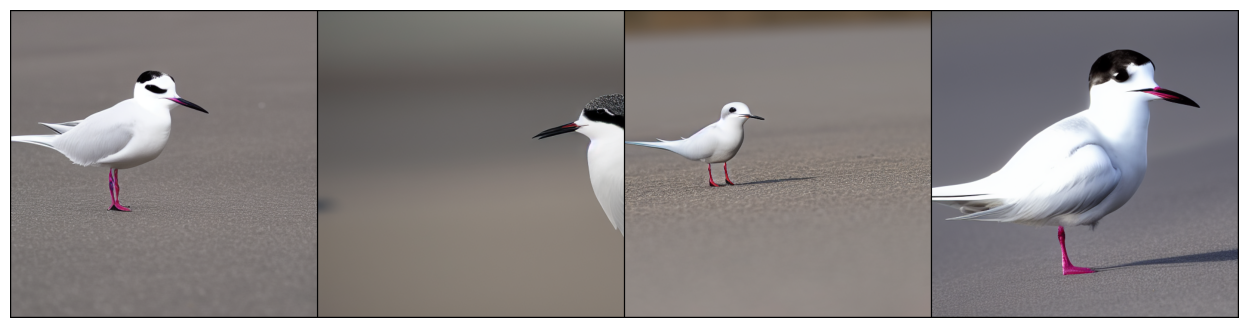

In [4]:
bs = 4
prompt = ['photo of a Artic Tern on road']*bs
img_list = pipe(
    prompt=prompt,
    num_inference_steps=50,
    guidance_scale=6,
    callback=None,
    callback_steps=1).images
img = visualize_images(img_list, outpath='ewc_shareTI_weight-1.pdf',
                       nrow=bs, show=True, save=False)

## Masked attention projection

In [ ]:
from reg_lora.modules import CLIPTiTextModel
text_encoder = CLIPTiTextModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="text_encoder",
    revision=None,
    mask_identifier_causal_attention=True,
    class_token_len=1,
    placeholder_token_id=49408,  # We only support on placeholder token for now
    local_files_only=True,
).to(device, dtype=weight_dtype)

In [ ]:
import copy
from functools import partial
import sys

lora_ckpts = [
    '../outputs/checkpoints/dog/TiReg/TiReg_norm0.37_MaskPlaceholder_weight_0_rank_10_seed_0/lora_weight_s100.safetensors',
    '../outputs/checkpoints/dog/TiReg/TiReg_norm0.37_MaskPlaceholder_weight_0_rank_10_seed_0/lora_weight_s500.safetensors',
    '../outputs/checkpoints/dog/TiReg/TiReg_norm0.37_MaskPlaceholder_weight_0_rank_10_seed_0/lora_weight_s1000.safetensors',
    '../outputs/checkpoints/dog/TiReg/TiReg_norm0.37_MaskPlaceholder_weight_0_rank_10_seed_0/lora_weight_s2000.safetensors',
]

prompts = ['a photo of a <krk1> dog swimming in a pool']
bs = 4
num_inference_steps = 50
weight_dtype = torch.float16
use_scale = False

latents = torch.randn((bs, 4, 64, 64), device=device, dtype=weight_dtype)
# pipe_copy.text_encoder = my_text_encoder
img_list = []
for lora_ckpt in lora_ckpts:
    pipe_copy = copy.deepcopy(pipe).to(device)
    pipe_copy.text_encoder = text_encoder
    torch.manual_seed(2)
    patch_pipe(
        pipe_copy,
        lora_ckpt,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str='cross'
    )
    # pipe.unet
    tune_lora_scale(pipe_copy.unet, 0)

    pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype)
    # tune_lora_scale(pipe_copy.text_encoder, 1)
    for prompt in prompts:
        prompt = [prompt]*bs
        img = pipe_copy(prompt=prompt,
                        num_inference_steps=num_inference_steps,
                        guidance_scale=6,
                        latents=latents,
                        callback=None,
                        callback_steps=1).images
        img_list.extend(img)
img = visualize_images(img_list, outpath='ewc_shareTI_weight-1.pdf',
                       nrow=bs*len(prompts), show=True, save=False)

## Fisher

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob

path_list = glob.glob(
    '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/wooden_pot/ewc_reg_shareTI/ewc_gen_weight_0.01_rank_10_seed_*/fisher.pt')
path_list.extend(glob.glob(
    '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/wooden_pot/ewc_reg_shareTI/ewc_real_weight_0.01_rank_10_seed_*/fisher.pt'))
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
for path in path_list:
    ewc_statics = torch.load(path)
    fishers = ewc_statics['fisher_list']
    lora_ups = ewc_statics['lora_up_list']
    lora_downs = ewc_statics['lora_down_list']
    fisher_mean = [fisher.pow(2).cpu().numpy().mean() for fisher in fishers]
    lora_down_mean = [lora_down.pow(2).cpu().numpy().mean()
                      for lora_down in lora_downs]
    axes[0].plot(fisher_mean)
    axes[1].plot(lora_down_mean)
plt.show()

In [ ]:
from lora_diffusion.lora import filter_unet_to_norm_weights
from safetensors.torch import safe_open
import sys
sys.path.append('../')
lora_ckpt = '../outputs/checkpoints/dog/ewc_reg_shareTI/freeze-down_lora_rank_10/lora_weight_s1100.safetensors'
patch_pipe(
    pipe,
    lora_ckpt,
    patch_text=False,
    patch_ti=True,
    patch_unet=True,
    filter_crossattn_str='cross+self'
)
to_reg_params = filter_unet_to_norm_weights(
    pipe.unet, target_replace_module=UNET_CROSSATTN_TARGET_REPLACE)
lora_up_list = []
lora_down_list = []
for module in to_reg_params["other_loras"]:
    lora_up_list.append(module.lora_up.weight.data.norm().cpu())
    lora_down_list.append(module.lora_down.weight.data.mean().cpu())
plt.plot(lora_up_list, label='lora_up')
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
fig, axs = plt.subplots(8, 4, figsize=(20, 10))
for i in range(len(fishers)):
    fisher = fishers[i].cpu().numpy().flatten()
    mean = fisher.mean()
    fisher = fisher/mean
    axs[i//4, i % 4].hist(fisher, bins=100)
    axs[i//4, i % 4].tick_params(labelsize=5)
    # plt.hist(fishers[i].cpu().numpy().flatten(), bins=100)
    # plt.show()
plt.savefig('fisher_distribution.pdf')
plt.show()

In [ ]:
for fisher in fishers:
    fisher = fisher.cpu().numpy()
    mean = fisher.mean()
    fisher = fisher/mean

In [ ]:
import torch
a = torch.randn(3, 3).pow(2)/100
det_a = torch.det(a)
norm_a = a.norm(2)
a_norm = a / norm_a
norm_a